In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import missingno as msno
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import warnings
warnings.simplefilter('ignore') # 
from pandarallel import pandarallel
 
# Initialization
pandarallel.initialize()

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
IdioVol = pd.read_csv('IdioVolAHT.csv')
Beta = pd.read_csv('Beta.csv')

In [3]:
df = pd.merge(Beta,IdioVol,on=['yyyymm','permno'],how='outer')

In [4]:
df_g = df.groupby('permno')[['Beta','IdioVolAHT']].mean().reset_index()

In [5]:
df_g.dropna(inplace=True)

In [6]:
df_g['IdioVolAHT'] = df_g['IdioVolAHT']*np.sqrt(12)

In [7]:
df_g['vol_mkt'] = np.sqrt(0.2)

In [9]:
alpha = pd.read_csv('CAPM_beta_alpha_756days_min252days.csv')

In [10]:
avg_alpha = alpha[['PERMNO','DATE','alpha']].groupby('PERMNO')['alpha'].mean()

In [11]:
avg_alpha = avg_alpha*252

In [12]:
avg_alpha = avg_alpha.to_frame().reset_index()

In [13]:
avg_alpha.rename(columns={'PERMNO':'permno'},inplace=True)

In [14]:
df_g = df_g.merge(avg_alpha,on='permno',how='left')

In [15]:
df_g.dropna(inplace=True)

In [30]:
# Define the function to calculate portfolio variance and Sharpe ratio
def calculate_portfolio_metrics(df, N, simulations=10000, risk_free_rate=0.06):
    portfolio_variances = []
    portfolio_sharpe_ratios = []
    
    for _ in range(simulations):
        sampled_df = df.sample(n=N, replace=False)
        beta_i = sampled_df['Beta'].values
        alpha_i = sampled_df['alpha'].values
        idio_vol_i = sampled_df['IdioVolAHT'].values
        vol_mkt = sampled_df['vol_mkt'].values[0]
        
        # Calculate portfolio variance
        term1 = 2 * np.sum(beta_i[:, None] * beta_i[None, :] * vol_mkt ** 2) / N ** 2
        term2 = np.sum(beta_i ** 2 * vol_mkt ** 2 + idio_vol_i ** 2) / N ** 2
        portfolio_variance = term1 + term2
        portfolio_variances.append(portfolio_variance)
        
        # Calculate average alpha and beta
        avg_alpha = np.mean(alpha_i)
        avg_beta = np.mean(beta_i)
        
        # Calculate portfolio Sharpe ratio
        portfolio_sharpe_ratio = (avg_alpha + avg_beta * risk_free_rate) / portfolio_variance
        portfolio_sharpe_ratios.append(portfolio_sharpe_ratio)
    
    return np.mean(portfolio_variances), np.mean(portfolio_sharpe_ratios)

# Prepare to store results
N_values = range(2, 401)
average_portfolio_variances = []
average_portfolio_sharpe_ratios = []

# Perform simulations for each N with a progress bar
for N in tqdm(N_values, desc="Calculating Portfolio Metrics"):
    avg_var, avg_sharpe = calculate_portfolio_metrics(df_g, N)
    average_portfolio_variances.append(avg_var)
    average_portfolio_sharpe_ratios.append(avg_sharpe)

# Create a dataframe for the results
results_df = pd.DataFrame({
    'N': N_values,
    'Average Portfolio Variance': average_portfolio_variances,
    'Average Portfolio Sharpe Ratio': average_portfolio_sharpe_ratios
})

Calculating Portfolio Metrics: 100%|██████████| 399/399 [23:52<00:00,  3.59s/it]


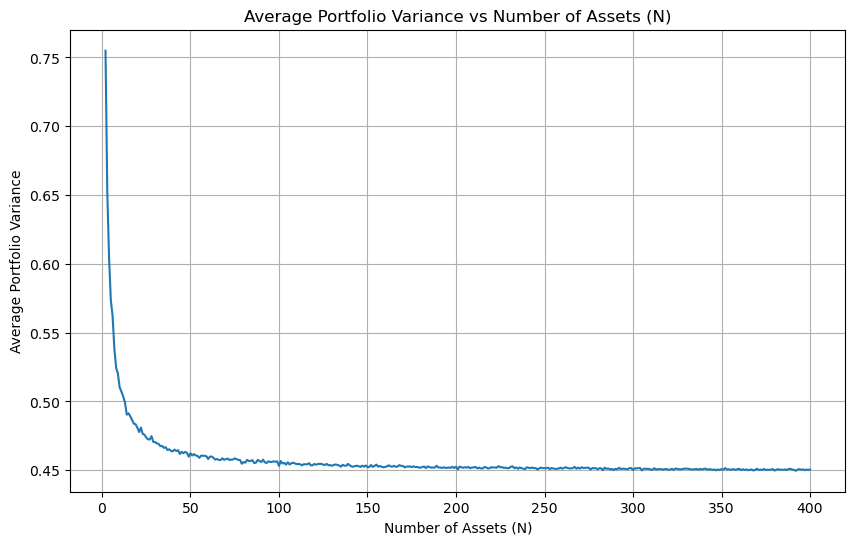

In [31]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['N'], results_df['Average Portfolio Variance'])
plt.title('Average Portfolio Variance vs Number of Assets (N)')
plt.xlabel('Number of Assets (N)')
plt.ylabel('Average Portfolio Variance')
plt.grid(True)
plt.show()

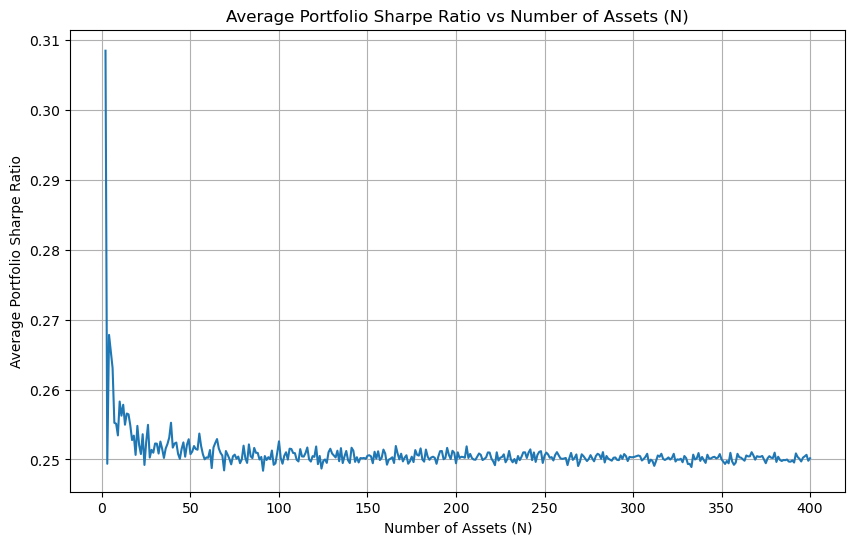

In [32]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['N'], results_df['Average Portfolio Sharpe Ratio'])
plt.title('Average Portfolio Sharpe Ratio vs Number of Assets (N)')
plt.xlabel('Number of Assets (N)')
plt.ylabel('Average Portfolio Sharpe Ratio')
plt.grid(True)
plt.show()